# Network Analysis of Flight Data

Many large data sets have a network dimensionality (social networks, peer-to peer file transfer, bitcoin, organisation, supply chain, connected systems etc.). Practical applications of network analysis include understanding its resilience to disturbances, robustness to attacks, and efficiency of processes on networks (information, energy transfer). The techniques draw knowledge from applied statistics, applied physics, graph theory, and data science. More recent advances have developed graph neural networks to discover graph features to quantify challenging behaviour. 

This study will be to apply feature-based graph analysis to flight data to demonstrate multi-scale graph analysis. The aim is to represent important notions in a low data dimension to enable effective communication and dissemination.

The objectives of this study will be to:
1. Transform 1 chosen month of flight data into network form and visualise it.
2. Implement graph analysis across 3 different scales: 
    1. macro-scale (Statistical analysis), 
    2. meso-scale (community analysis), 
    3. node-level (centrality analysis).
3. Assess and discuss the 3 different graph analysis scales and what they mean for air transport networks in real socioeconomic and engineering terms.

In [1]:
# Import necessary packages
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import seaborn as sns
import cartopy.feature as cfeature
from IPython.display import Image
from matplotlib import style

In [2]:
def Weighted_Distribution_Plot(G, colour:str, country:str):
    """
    Creates the weighted distribution plot for the network G.

    Weighted distribution visualises the distribution of nodes by the number of connections they have.
    Parameters:
    - G: Network from flight data
    - colour (str): Sets the colour of the plots
    - country (str): Specify the country
    """
    degree_sequence = sorted([d for n, d in G.degree(weight='Weight')], reverse=True)
    plt.style.use('dark_background')
    plt.figure(figsize=(7,5))
    plt.plot(degree_sequence, colour, marker=".")
    plt.yscale("log")
    plt.ylabel("Weighted Degree")
    plt.xlabel("Rank")
    plt.savefig(f'plots/Weighted_Degree-{country}.png', bbox_inches='tight', dpi=200)
    plt.show()

In [3]:
def Degree_Betweeness_Distribution(G, colour:str, country:str):
    """
    Creates the Degree vs Betweeness Distribution plot for the network G.

    Betweeness is the measure of the number of random traveller pathways through the node.

    Parameters:
    - G: Network from flight data
    - colour (str): Sets the colour of the plots
    - country (str): Specify the country
    """
    bet_cen = nx.betweenness_centrality(G, weight='Weight') # Compute the betweenness centrality of T: bet_cen
    deg_cen = nx.degree_centrality(G) # Compute the degree centrality of T: deg_cen
    plt.figure(figsize=(7,5))
    plt.scatter(list(deg_cen.values()),list(bet_cen.values()), c=colour, s=70) # Create a scatter plot of betweenness centrality and degree centrality
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel('Degree (log scale)')
    plt.ylabel('Betweeness (log scale)')
    plt.savefig(f'plots/Degree_Betweeness-{country}.png', bbox_inches='tight', dpi=200)
    plt.show()   

In [4]:
def Assortativity(G, colour:str, country:str):
    """
    Calculates and plots the assortativity of the network.

    Assortativity is a measure of the similarity of connections with respect to the node degree in the graph.
    
    Parameters:
    - G: Network from flight data
    - colour (str): Sets the colour of the plots
    - country (str): Specify the country
    """
    pearson = nx.degree_pearson_correlation_coefficient(G, x = 'out', y = 'in')
    print(f'{country}\'s Assortativity: {pearson}')

    Avg_Neigh_Deg = nx.average_neighbor_degree(G, source = 'out', target = 'in')
    Sorted_Avg_Neigh_Deg = sorted(Avg_Neigh_Deg.items(), reverse=True)
    degrees_node_weight = sorted([(n,d) for n, d in G.degree], reverse=True)
    dF1 = pd.DataFrame(degrees_node_weight, columns = ['node', 'Degree'])
    dF2 = pd.DataFrame(Sorted_Avg_Neigh_Deg, columns= ['node', 'Neighbor'])
    style.use('dark_background')
    plt.figure(figsize=(7,5))
    plt.scatter(dF1['Degree'], dF2['Neighbor'],c=colour, s=60, marker="o")
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Node Degree (log scale)')
    plt.ylabel('Average neighbor degree (log scale)')
    plt.savefig(f'plots/Assortativity-{country}.png', bbox_inches='tight', dpi=200)
    plt.show()

In [5]:
def Grapher(G, extents:list, colour:str, colourmap:str, country:str, airports_dict:dict):
    """
    Creates the network map from the network G.
    
    Parameters:
    - G: Network from flight data
    - extents (list): List of coordinates to set the boundaries of the geographical plot
    - colour (str): Specify colour of the plot
    - colourmap (str): Specify the colourmap of the plot
    - country (str): Specify country for the plot
    - airports_dict (dict): Dictionary of airports iata code and their location.
    """
    # Create graph properties
    edges, weights = zip(*nx.get_edge_attributes(G,'Weight').items())

    # Map projection
    crs = ccrs.PlateCarree()
    fig, ax = plt.subplots(1, 1, figsize=(15, 15),
    subplot_kw=dict(projection=crs))
    ax.add_feature(cfeature.COASTLINE, edgecolor = 'white')
    ax.add_feature(cfeature.BORDERS, edgecolor = 'white')
    # Extent of continental US.
    ax.set_extent(extents)
    nx.draw_networkx(G, ax = ax,
                font_size = 16,
                font_color = 'white',
                alpha = 0.6,
                width = .6,
                node_size = 200,
                with_labels = False,
                pos = airports_dict,
                node_color = colour,
                edge_color = weights,
                edge_cmap = colourmap)
    fig.savefig(f'plots/Map-{country}.png', bbox_inches='tight', dpi=200)


In [6]:
def core_community(G, extents:list, country:str, airports_dict:dict):
    """
    Plot the nodes which are part of the core community.

    Parameters:
    - G: Network from flight data.
    - extents (list): List of coordinates to set the boundaries of the geographical plot
    - country (str): Specify country for the plot
    - airports_dict (dict): Dictionary of airports iata code and their location.

    Returns:
    size: Size of the core community.
    """
    size =[]
    # Calculate Core
    try:
        c_network = nx.k_core(G, core_number=nx.core_number(G))
    except nx.exception.NetworkXError:
        g = G
        g.remove_edges_from(list(nx.selfloop_edges(g)))
        c_network = nx.k_core(g, core_number=nx.core_number(g))
    size.append(len(c_network))

    # Map projection
    crs = ccrs.PlateCarree()
    fig, ax = plt.subplots(1, 1, figsize=(15, 15),
    subplot_kw=dict(projection=crs))

    style.use('dark_background')
    ax.add_feature(cfeature.COASTLINE, edgecolor = 'white')
    ax.add_feature(cfeature.BORDERS, edgecolor = 'white')

    # Extent of continental US.
    ax.set_extent(extents)
    nx.draw_networkx(c_network, ax = ax,
                font_size   = 15,
                font_color  = 'black',
                font_family = 'DejaVu Sans',
                alpha       = 1,
                width       = 1,
                node_size   = 1000,
                pos         = airports_dict,
                with_labels = True,
                edge_color  = 'grey',
                node_color  = 'white')
    fig.savefig(f'plots/Core_Map-{country}.png', bbox_inches='tight', dpi=200)
    plt.show()
    return size

In [7]:
def core_community_k(G, size:int, country:str, colour:str):
    """
    Calculates the core community size of the network and creates a graph.

    Understanding the core nodes of the network provides indication what are the critical nodes of the network. Core nodes are those with high degrees and are densely connected with each other. Highly ranked nodes with even higher ranked nodes contribute to the constitution of the core, however if the nodes have few links to high degree nodes then this can be classified as part of the periphery (Ma & Mondragon, 2015).

    Parameters:
    - G: Network from flight data.
    - size (int): List of coordinates to set the boundaries of the geographical plot
    - country (str): Specify country for the plot
    - colour (str): Specify colour of the plot
    """
    Sorted_Degrees = [(n, v) for (n, v) in sorted(G.degree, key = lambda x: x[1], reverse = True)]
    dF = pd.DataFrame(Sorted_Degrees).rename(columns = {0:'id', 1:'Degree'}, inplace = False)
    dF['Rank'] = dF['Degree'].rank(ascending = False)
    link_list = []
    for id in dF['id']:
        count = 0
        for i in G.neighbors(id):
            if dF[dF['id'] == i].iloc[0]['Degree'] > dF[dF['id'] == id].iloc[0]['Degree']:
                count = count + 1
        link_list.append(count)
        
    dF2 = pd.DataFrame([v for (n, v) in sorted(G.degree, key = lambda x: x[1], reverse = False)]).rename(columns = {0:'Rank'}).rank(axis = 0, method = 'first')
    dF2['Link List'] = link_list
    Peak_Degree = dF2[dF2['Link List'] == dF2['Link List'].max()]

    if country == 'USA':
        w = 2
        # Core
        xc  = (Peak_Degree.iloc[0]['Rank']-2)
        yc  = 35
        dxc = -90
        dyc = 0
        xyc = (-55, 31)
        # Periphery
        xp  = (Peak_Degree.iloc[0]['Rank']+2)
        yp  = 35
        dxp = 600
        dyp = 0
        xyp = (300, 31)
    elif country == 'UK':
        w = 0.3
        # Core
        xc  = (Peak_Degree.iloc[0]['Rank']-2)
        yc  = 9.5
        dxc = -10
        dyc = 0
        xyc = (1, 8.5)
        # Periphery
        xp  = (Peak_Degree.iloc[0]['Rank']+2)
        yp  = 9.5
        dxp = 40
        dyp = 0
        xyp = (30, 8.5)
    elif country == 'Australia':
        w = 0.4
        # Core
        xc  = (Peak_Degree.iloc[0]['Rank']-2)
        yc  = 7
        dxc = -15
        dyc = 0
        xyc = (-10, 6)
        # Periphery
        xp  = (Peak_Degree.iloc[0]['Rank']+2)
        yp  = 7
        dxp = 100
        dyp = 0
        xyp = (60, 6)
    else:
        w = 0.5
        # Core
        xc  = (Peak_Degree.iloc[0]['Rank']-5)
        yc  = 20
        dxc = -30
        dyc = 0
        xyc = (1, 18)
        # Periphery
        xp  = (Peak_Degree.iloc[0]['Rank']+5)
        yp  = 20
        dxp = 100
        dyp = 0
        xyp = (60, 18)

    # Create graph
    # style.use('classic')
    sns.set_theme(style="darkgrid")
    sns.set(rc={"figure.figsize":(12, 4)}) # Define figure size
    sns.lineplot(data=dF2, x = 'Rank', y = 'Link List', color=colour)
    # Annotate Graph
    plt.arrow(x=xc, y=yc, dx=dxc, dy=dyc, width=w, facecolor='purple')
    plt.annotate('Core Nodes', xy = xyc)
    plt.arrow(x=xp, y=yp, dx=dxp, dy=dyp, width=w, facecolor='orange')
    plt.annotate('Periphery Nodes', xy = xyp)
    plt.axvline(Peak_Degree.iloc[0]['Rank'], color='r', ls = ':') # Indicate boundary
    # Plot properties
    plt.title('Core Community: {}'.format(country))
    plt.xlabel('Node Number (Ranked by Descending Degree)')
    plt.ylabel('No. of Connections to Higher Degree Nodes')
    plt.xscale('linear')
    plt.yscale('linear')
    plt.legend(['Core Community Size: {}'.format(size)], loc = "best")
    plt.savefig(f'plots/Core_Periphery-{country}.png', bbox_inches='tight', dpi=200)
    plt.show()

In [15]:
def country_graph(flight_data, country:str, extents:list, airports_dict:dict):
      G = nx.from_pandas_edgelist(flight_data, 'Source', 'Target', 'Weight', create_using=nx.DiGraph)
      G_multi = nx.from_pandas_edgelist(flight_data, 'Source', 'Target', 'Weight', create_using=nx.MultiDiGraph)
      print('Plotting graphs...')

      # Specify colours for graphs
      if country == 'USA':
            colour = 'blue'
            colourmap = plt.cm.Blues
      elif country == 'UK':
            colour = 'm'
            colourmap = plt.cm.Purples
      elif country == 'Australia':
            colour = 'orange'
            colourmap = plt.cm.Oranges
      else:
            colour = 'red'
            colourmap = plt.cm.Reds

      # Assortativity
      Assortativity(G, colour, country)

      # Weighted Distrubtution Plot
      Weighted_Distribution_Plot(G, colour, country)

      # Degree vs Betweenness Distribution
      Degree_Betweeness_Distribution(G, colour, country)

      # Create Graph
      Grapher(G_multi, extents, colour, colourmap, country, airports_dict)

      # Calculate communities
      size = core_community(G, extents, country, airports_dict)
      print(f"{country} - Community Size:{size[0]} \n")

      core_community_k(G, size, country, colour)

In [9]:
# Read flights data
flights = pd.read_excel(r"Data\Flight Data.xlsx", sheet_name=0, header=0) # Read the flight data
flights = flights[(flights['TimeSeries']=='2008-07-01')] # Filter out flights for July 2008

In [10]:
# Create the airport dictionary
airports = pd.read_csv(r"Data\Airports.csv") # Read airport data
airports_clean = airports[airports['iata_code'].notna()]
airports_dict = {d['iata_code']: (d['longitude_deg'], d['latitude_deg']) for d in airports_clean.to_dict(orient='records')}

In [11]:
# Clean the flights
airports_used = airports['iata_code'].dropna()
flights_pruned = flights[(flights.Source.isin(airports_used))&(flights.Target.isin(airports_used))]

In [12]:
Flight_Data_US = flights_pruned[(flights_pruned['Source Country']=='USA') & (flights_pruned['Target Country']=='USA')]
Flight_Data_UK = flights_pruned[(flights_pruned['Source Country']=='United Kingdom') & (flights_pruned['Target Country']=='United Kingdom')]
Flight_Data_China = flights_pruned[(flights_pruned['Source Country']=='China') & (flights_pruned['Target Country']=='China')]
Flight_Data_Australia = flights_pruned[(flights_pruned['Source Country']=='Australia') & (flights_pruned['Target Country']=='Australia')]

Plotting graphs...
UK's Assortativity: -0.18348754735383166


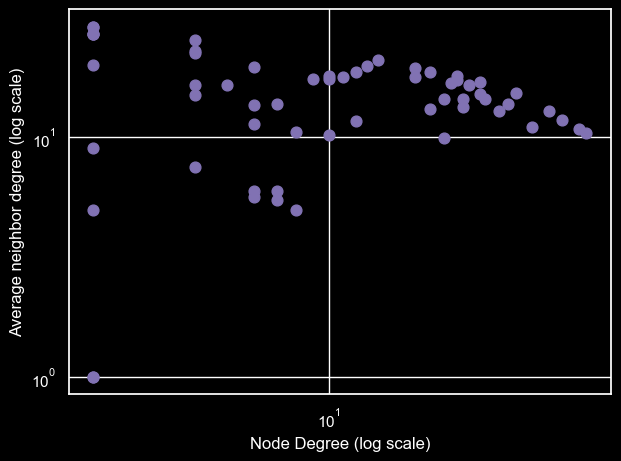

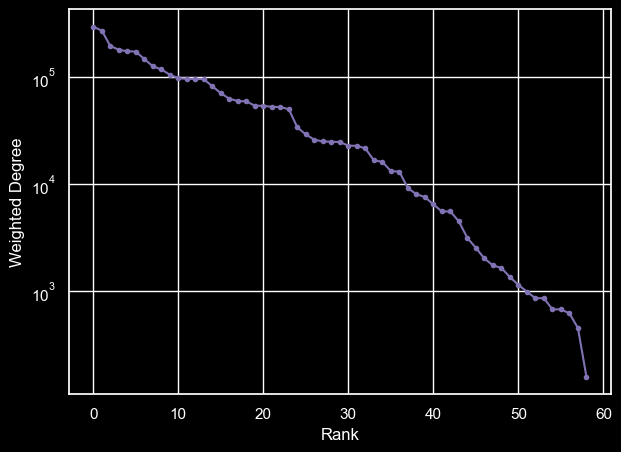

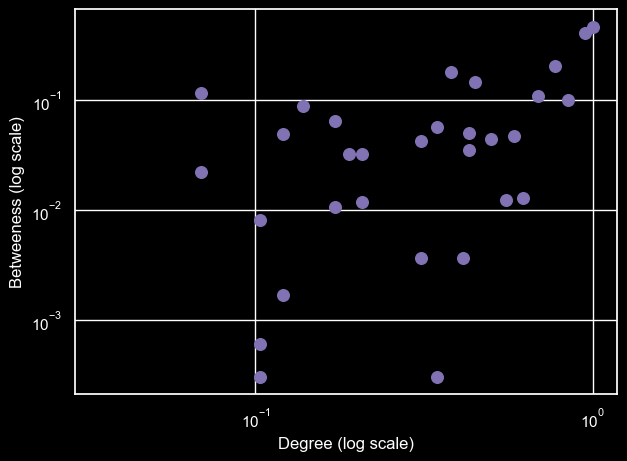

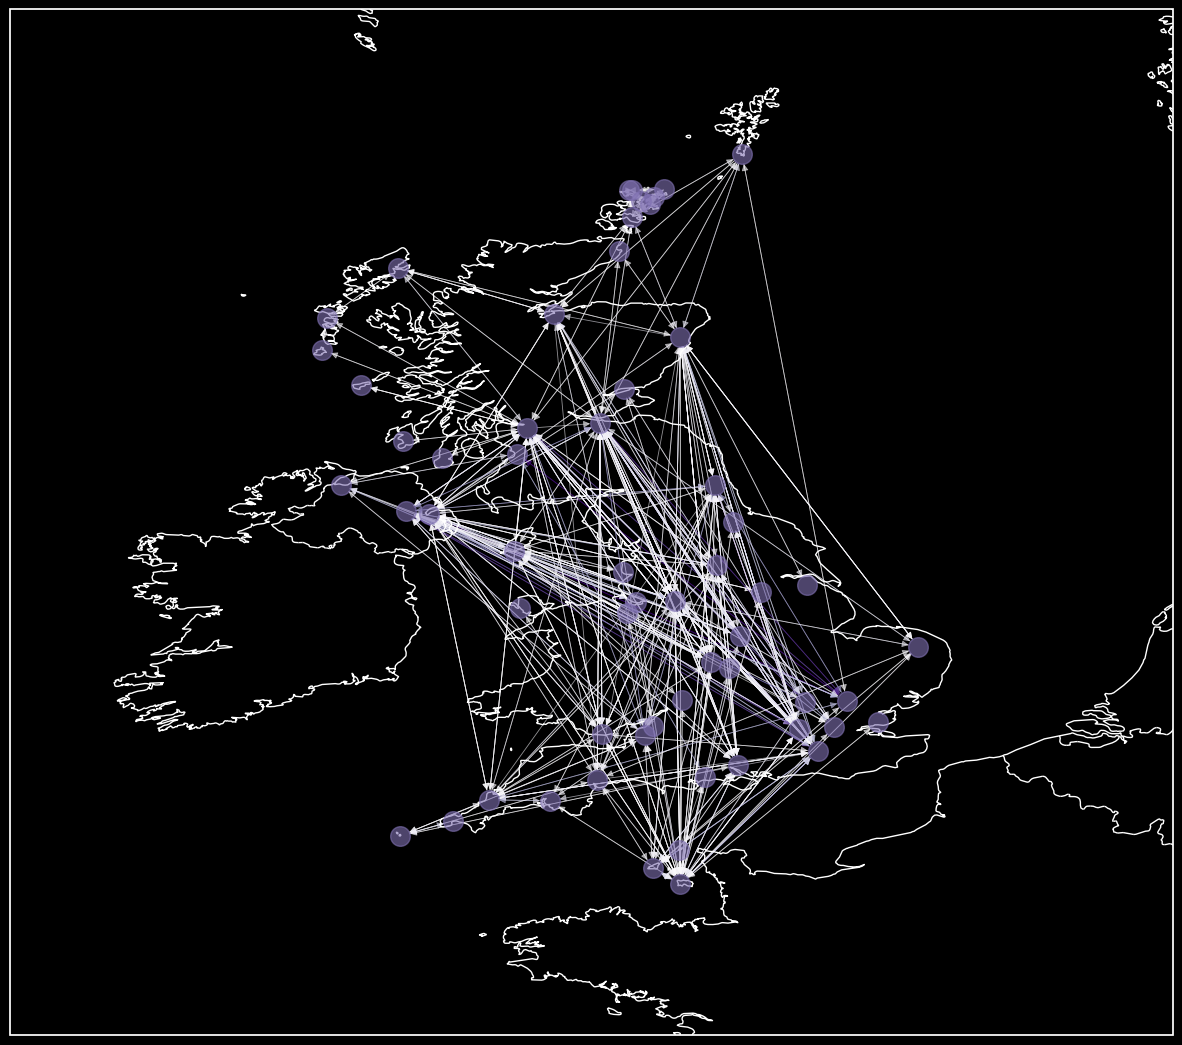

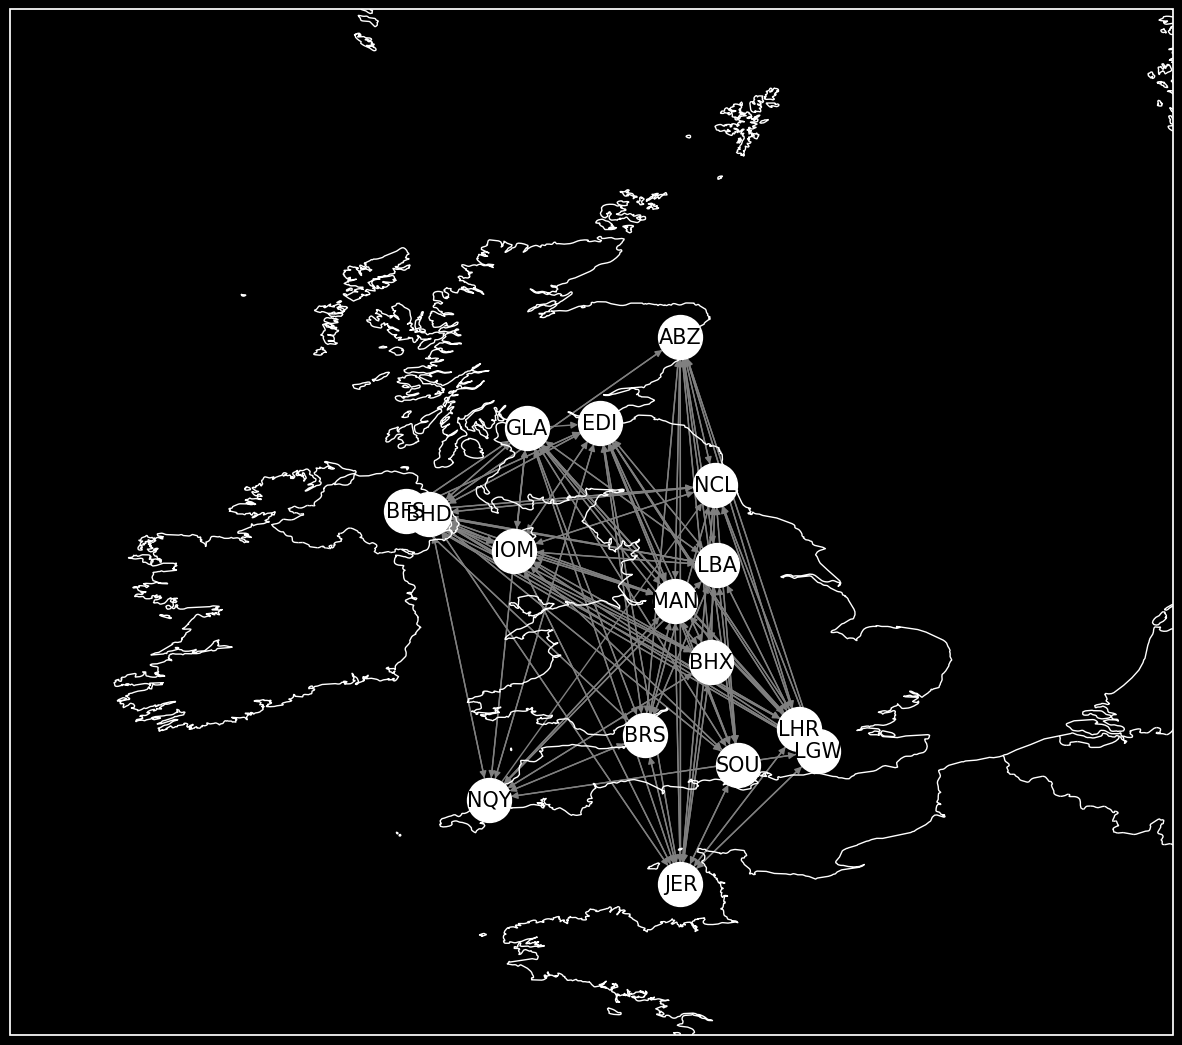

UK & Size:16 



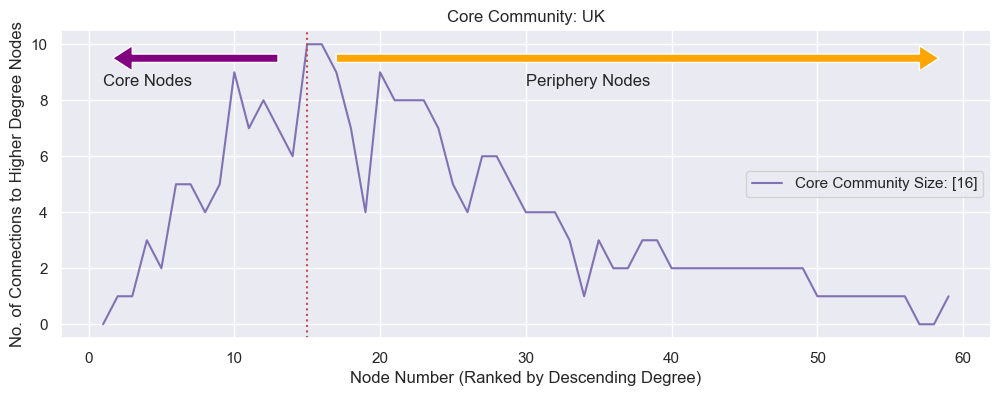

In [16]:
country_graph(Flight_Data_UK, 'UK', [-12, 5, 47,62], airports_dict)

Plotting graphs...
USA's Assortativity: -0.27273586827064306


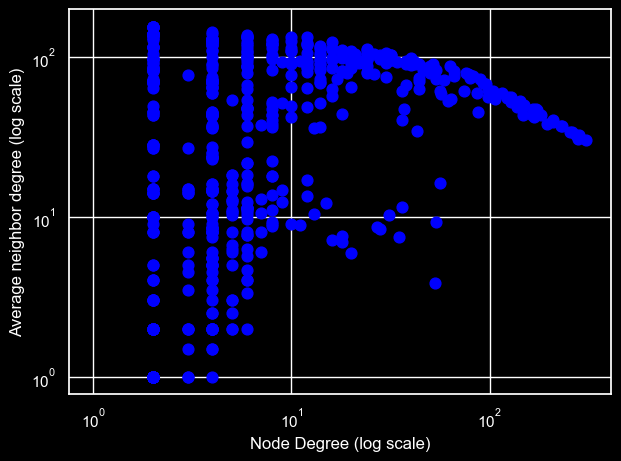

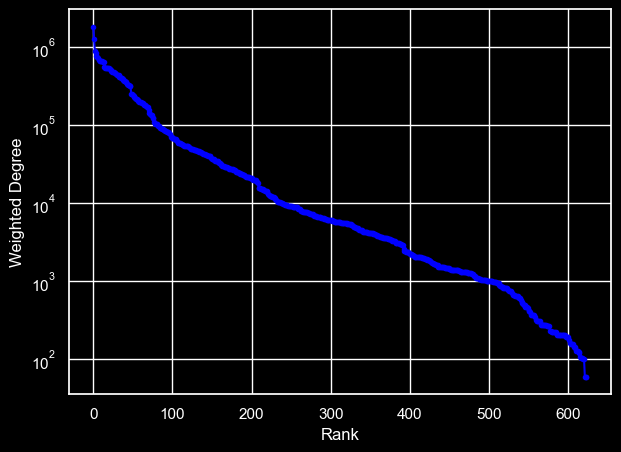

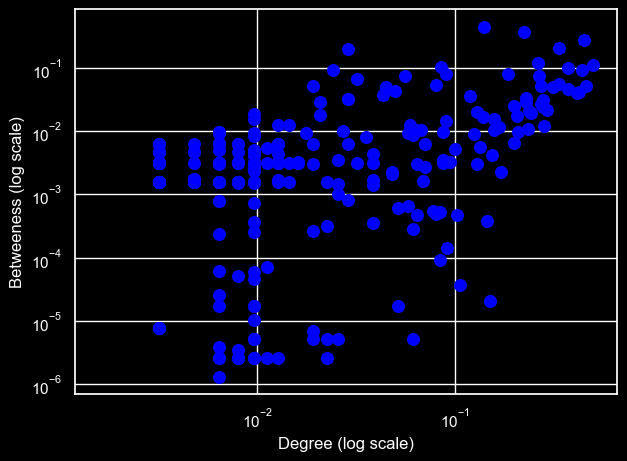

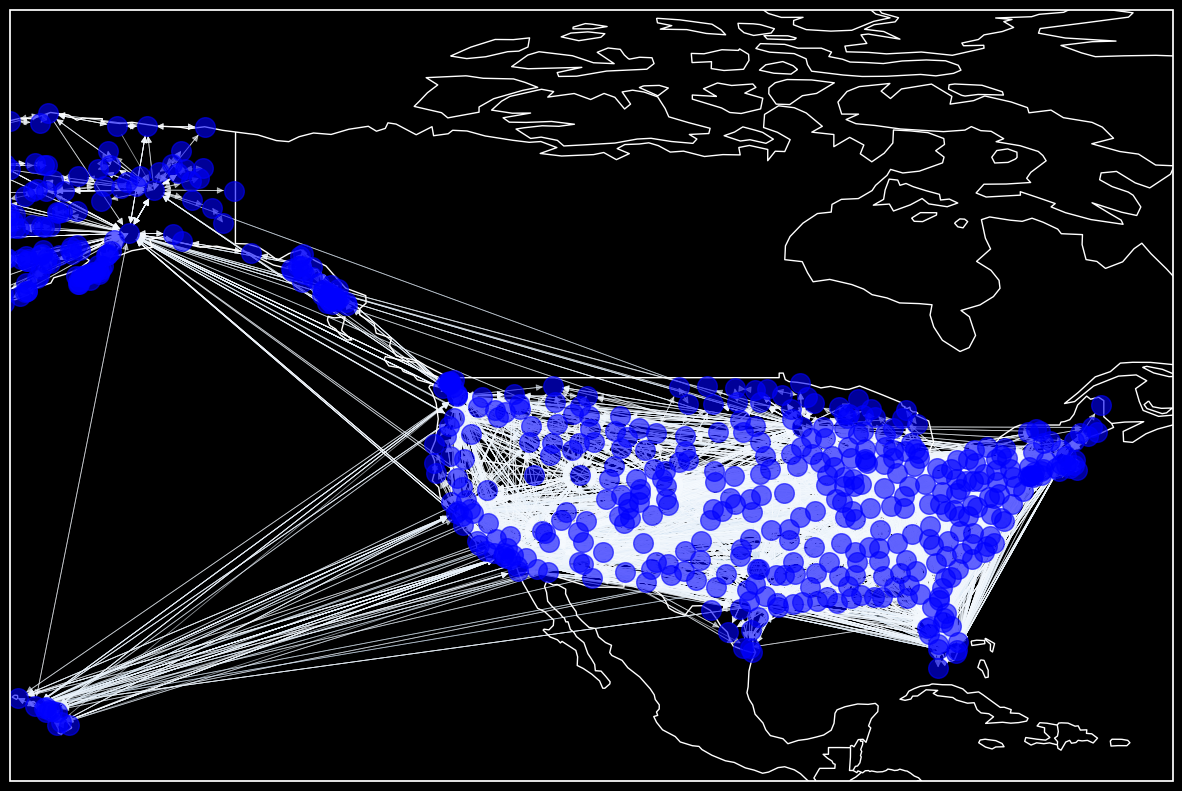

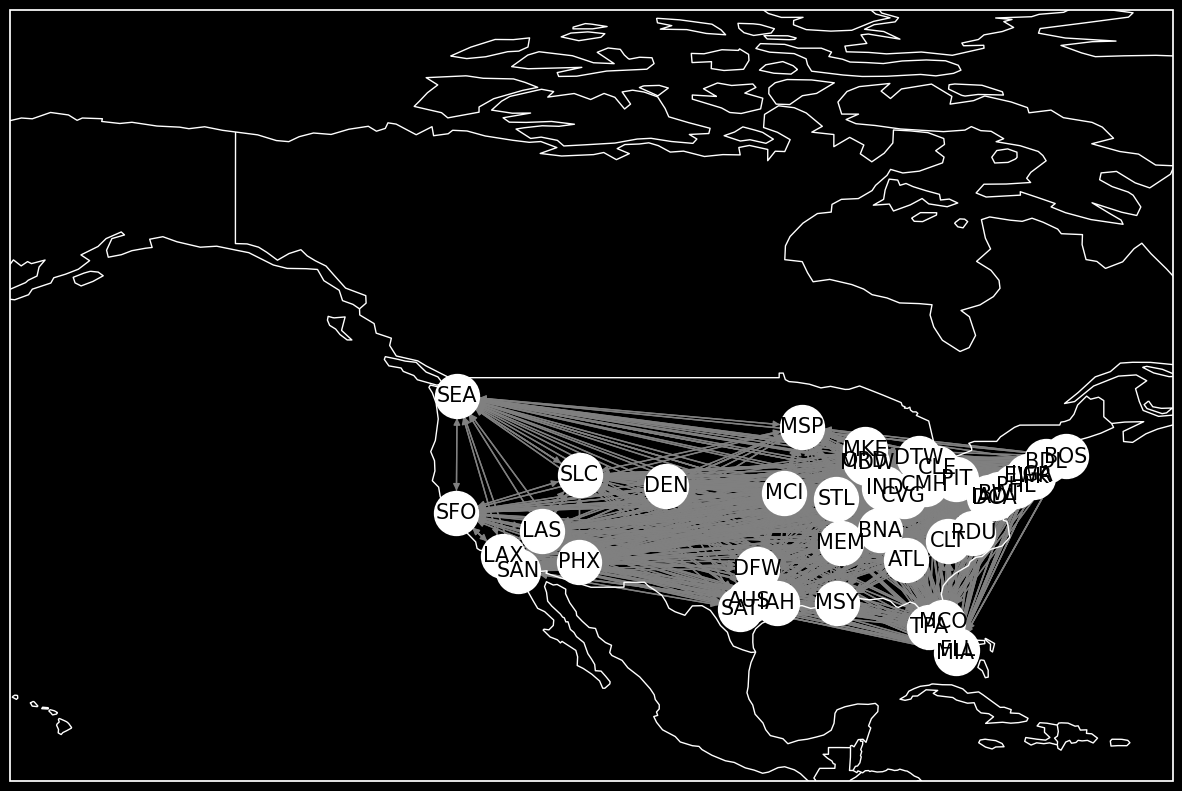

USA & Size:43 



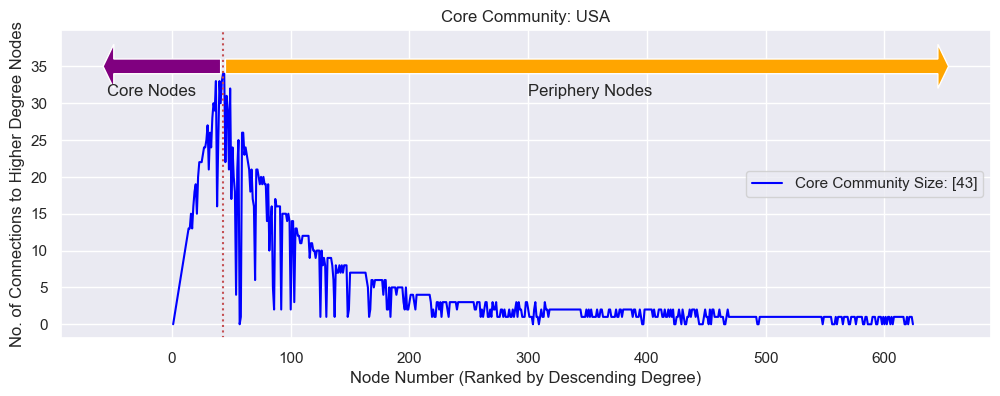

In [17]:
country_graph(Flight_Data_US, 'USA', [-160, -62, 15, 75], airports_dict)

Plotting graphs...
Australia's Assortativity: -0.3256459637893234


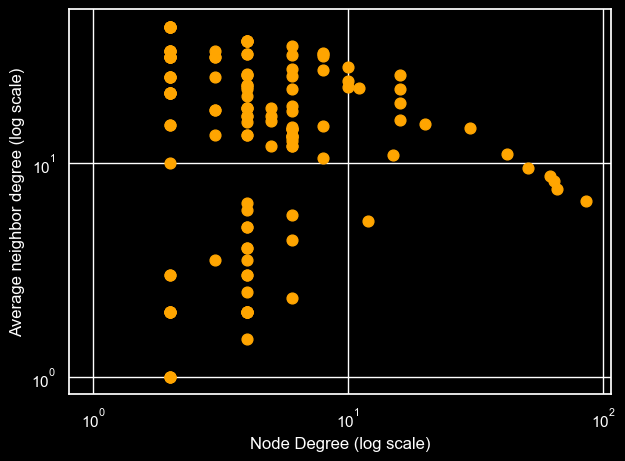

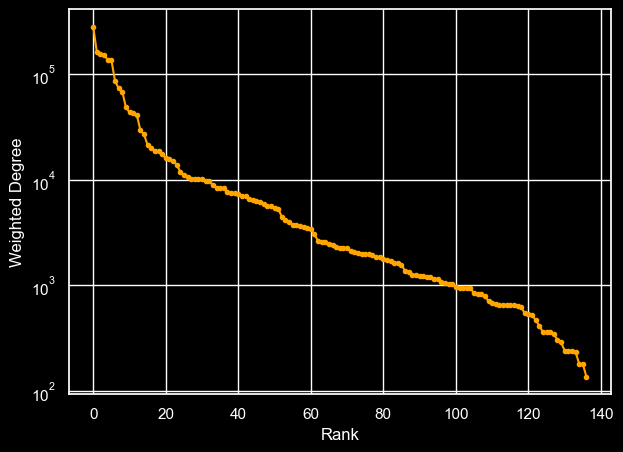

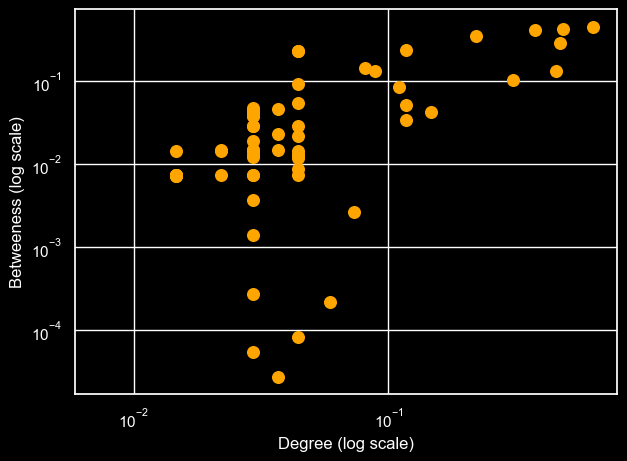

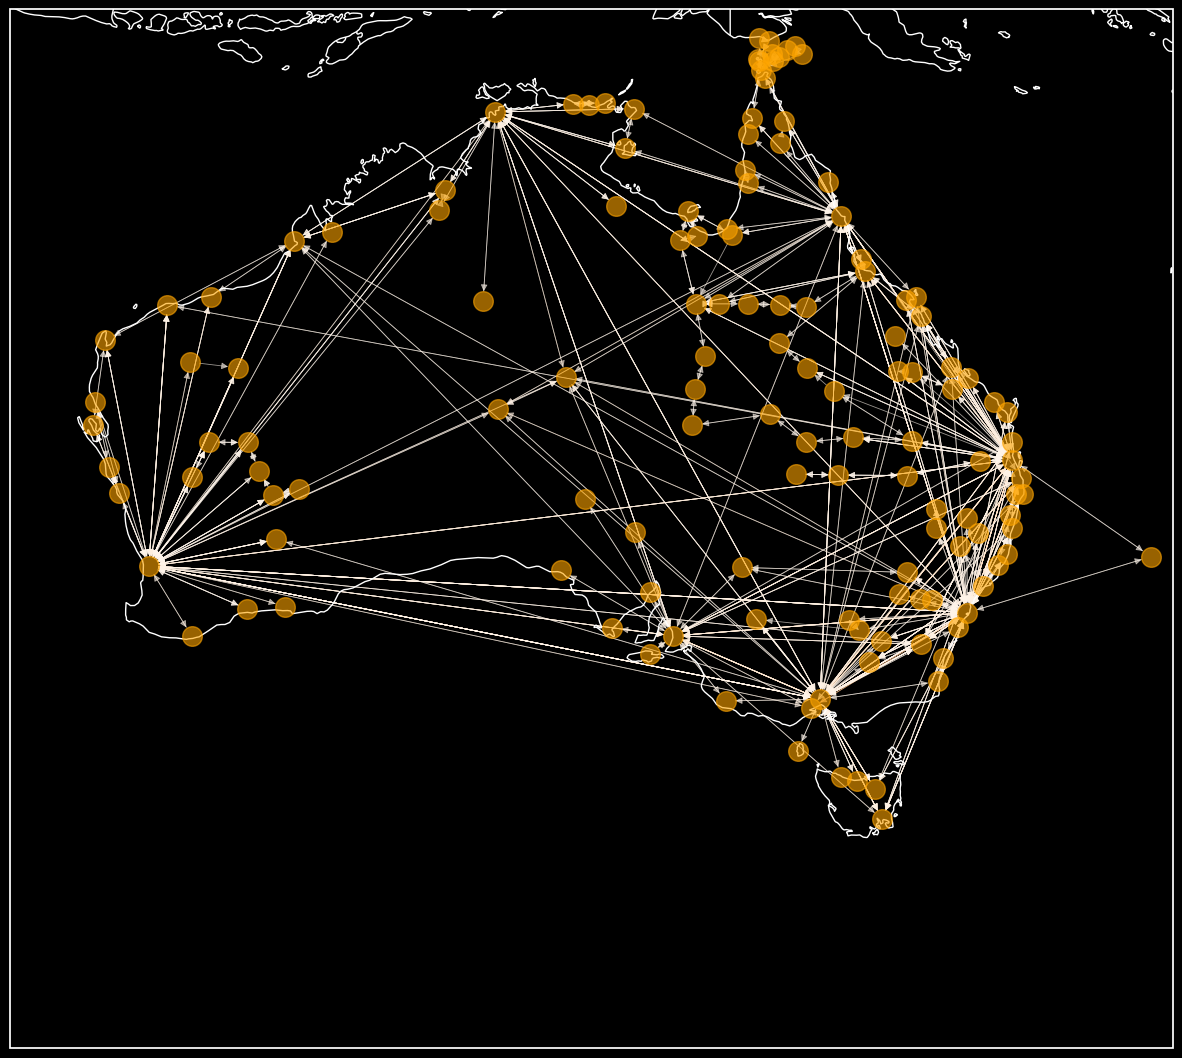

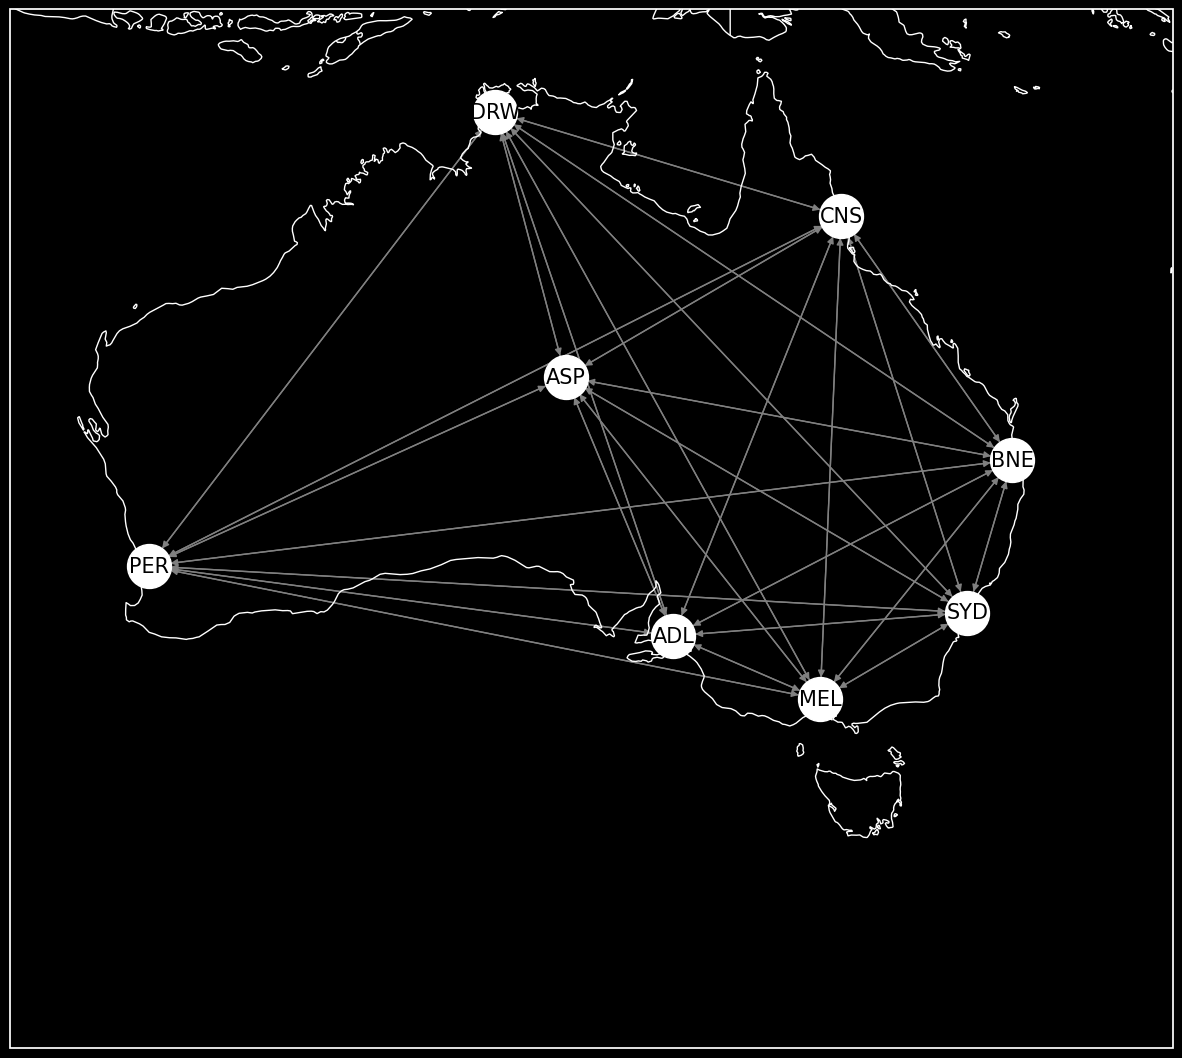

Australia & Size:8 



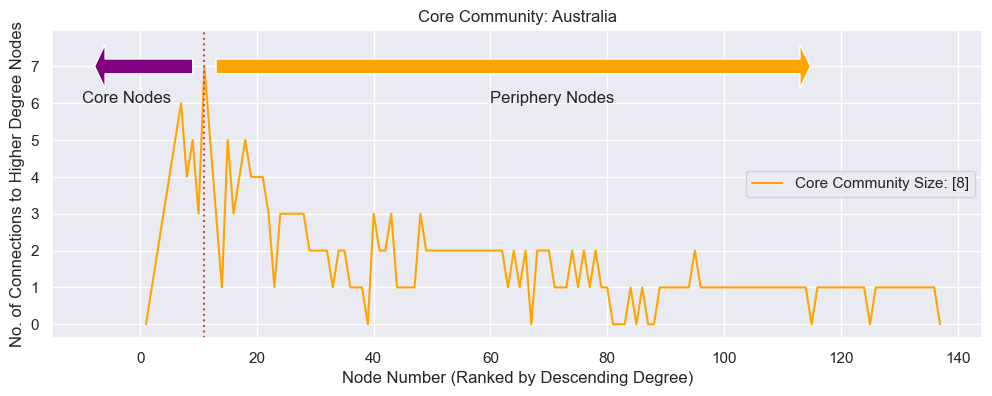

In [18]:
country_graph(Flight_Data_Australia,'Australia',[110, 160, -8, -50], airports_dict)

Plotting graphs...
China's Assortativity: -0.3885318563272703


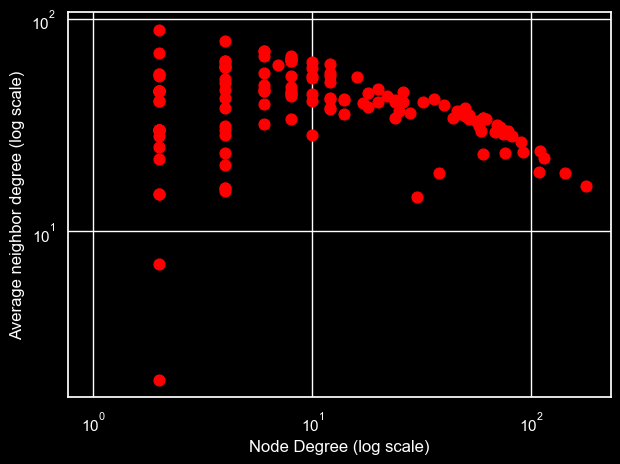

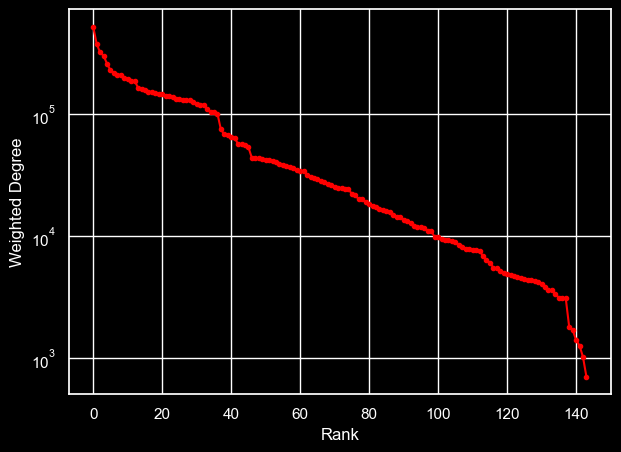

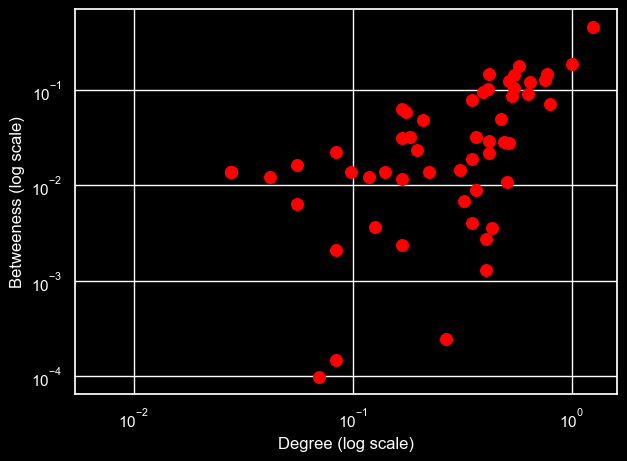

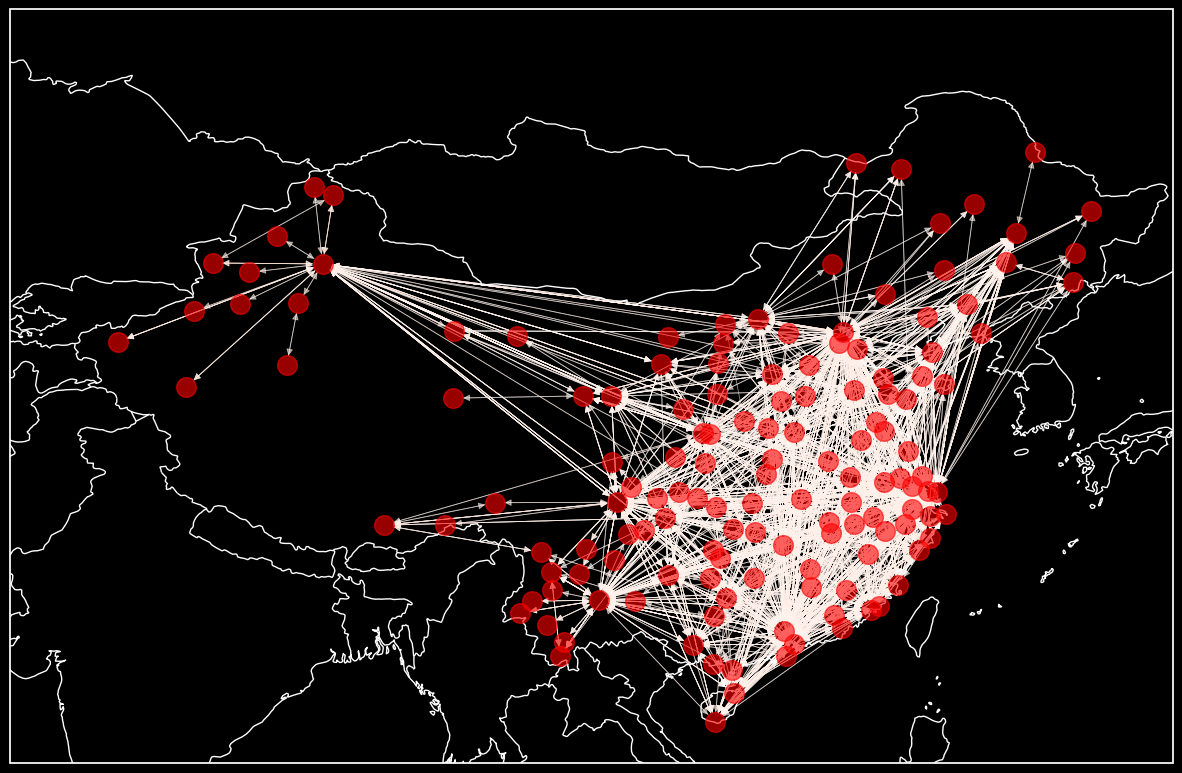

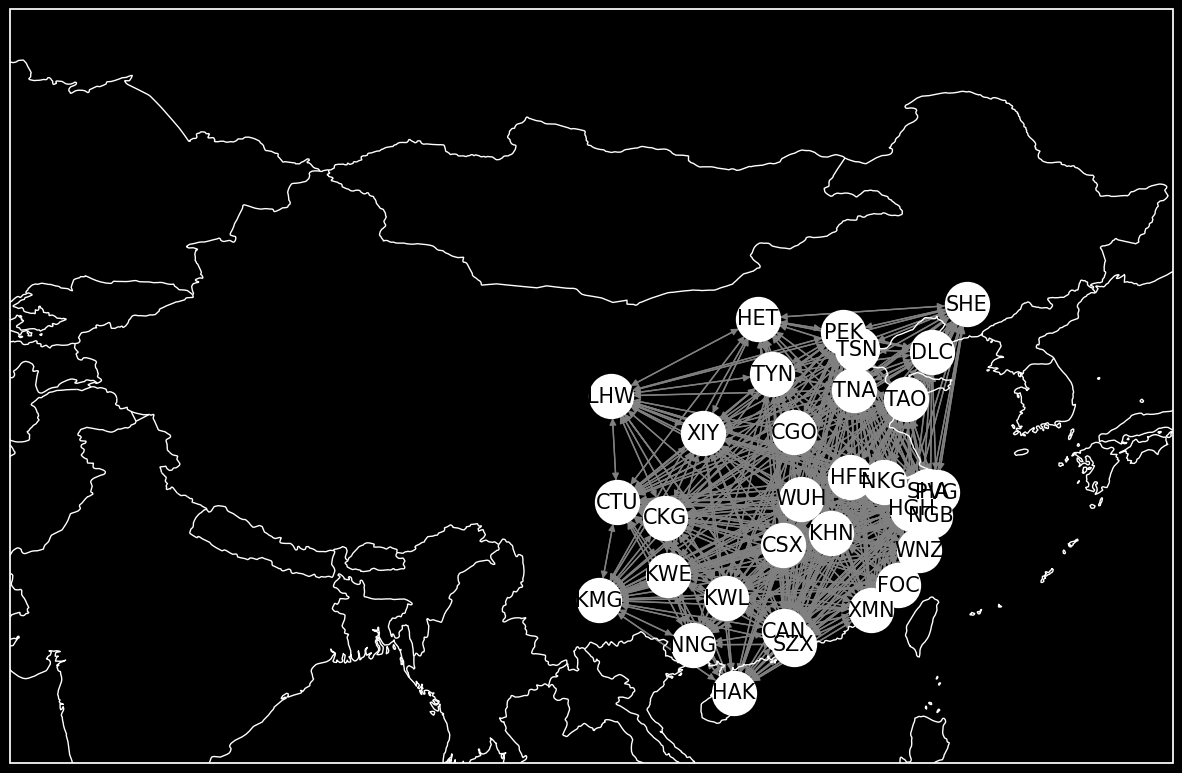

China & Size:32 



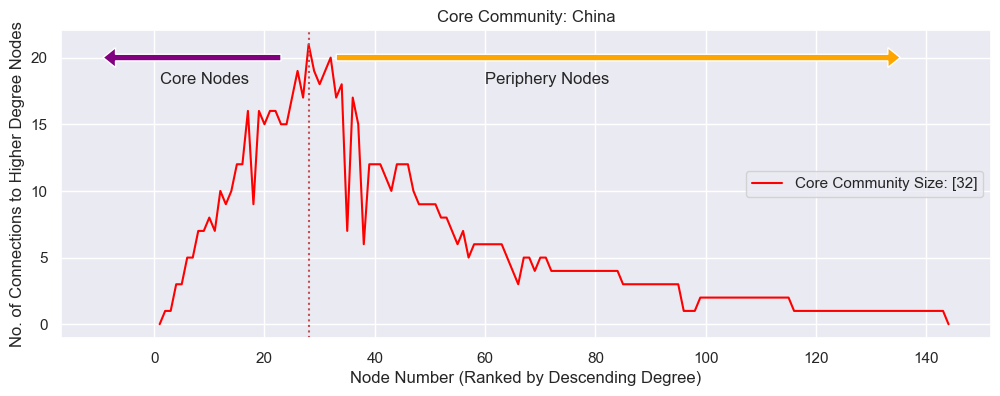

In [19]:
country_graph(Flight_Data_China,'China',[70, 135, 16, 54], airports_dict)

The weighted degree distributions show the classic King-Pauper effect. This is particularly evident in plots for the USA, China and Australia where at the either ends of the distributions there exists a sharp incline and sharp decline in the weighted degree of those nodes. The King effect occurs at the initial set of nodes where those nodes have a high number of connections and the Pauper effect where the nodes at the highest ranks have very low number of connections which do not follow the trend of the distribution. Those "King" nodes can also be regarded as the core nodes of the network. There are not as many domestic flights in the UK compared to the other countries and so the effect is less pronounced.

The Degree Between correlations shows the degree vs betweeness distributions for the four countries. Those airports with high betweeness will control the flow of flights as they act as vital connections to other groups of airports. Thus, when we see a high correlation between the degree and betweeness of nodes then those airports which are well connected will also connect travellers from any airport to another (the hub airports such as London Heathrow). Those airports which are low degree and high betweeness are vital but are not very well-connected. USA, Australia and China sees the distribution sharpening to the top right as we do not particularly see nodes of high degree and low betweeness. The UK distribution is less distinct however we do again see the sharpening to the top right of the plot.

The average neighbour degree of a node can be seen for plots USA, China and Australia. These plots are disassortative due to the negative slope at higher degree nodes. The airport hubs tend to not link with each other but have higher connections to smaller airports. China is the most disassortative as we do not see nodes of low degree have neighbours of low degree but rather the hubs are mostly connected to the smaller airports, and thus we can deduce that China’s network is characteristic of the hub and spoke model.

The average neighbour degree plots use the pearson correlation coefficient to calculate the assortativity for the whole network. We see that UK is the only assortative network but only by a small amount. This could be the case as the UK has far fewer flights. China is the most disassortative.

The method taken to detect the core is through determining the core periphery structure. This is done by arranging the nodes by the order of degree. For a particular node, the number of links k^+_
r with nodes with a higher degree is captured. With a generated k^+_r sequence plotted, the core boundary is determined by finding the peak of the sequence. After this point the number of links decreases.

Through the core periphery method, we are able to determine the size of the core which is 16 for the UK, 43 for the US, 32 for China and 8 for Australia from figure 9. As we already know which nodes are part of the core, figure 10 visualises those core nodes on the map. Considering the performance of the countries networks, The USA and Australia are less robust to targeted and random failures as the core nodes make up 7% and 6% respectively of the countries airport network. This is unlike the UK and China which has 27% and 22% and so are perhaps have better robustness and so can better survive against these failures. In terms of the economic efficiency USA and Australia are more efficient than UK and China.

# Conclusion
Analysis was performed on domestic flights from UK, USA, China and Australia from the year 2008. Graphs of those networks were created and a number of different metrics were plotted to understand and compare the different countries networks. It can be seen that China was the most disassortative network whilst the UK is the most assortative. Core community sizes for each country was calculated to be 16 for the UK, 43 for the US, 32 for China and 8 for Australia. The US and Australia being the most economically efficient however less robust to targeted and random failures.